# LSTM Neural Network Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

The following dataset is simulated according to the model: 
\begin{equation*}
   y_t = 0.9 \sin (0.5\pi y_{t - p}) + \epsilon_t
\end{equation*}
for some fixed $p$. This equation is for $t \geq p+1$. For $t \leq p$, we take $y_t$ to be linear. We take $p$ to be a large value. 

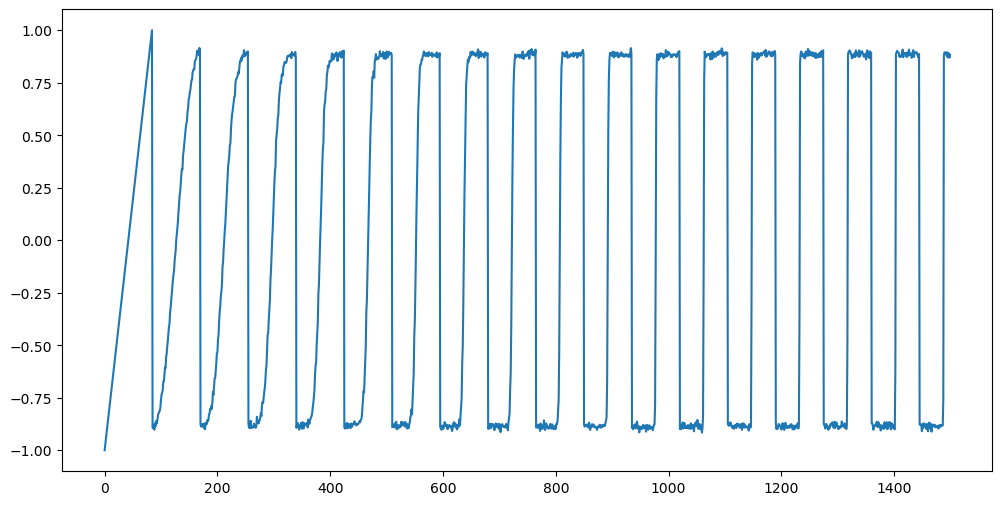

In [ ]:
n = 1500
truelag = 85
rng = np.random.default_rng(seed=0)
#sig_noise = 0.05
sig_noise = 0.01

eps = rng.normal(loc=0, scale=sig_noise, size=n)
y_sim = np.full(shape=n, fill_value=-999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = 0.9 * np.sin(0.5 * np.pi * y_sim[i - truelag]) + eps[i]
#y_sim = y_sim + eps

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

Let us obtain predictions for future values using the actual function $g(y) = 0.9 \sin(0.5 \pi y)$ from which the data were generated. These predictions (which we can refer to as Oracle Predictions) will form the benchmark which we can use to compare the predictions of various methods (AR, LSTM, RNN, GRU).  

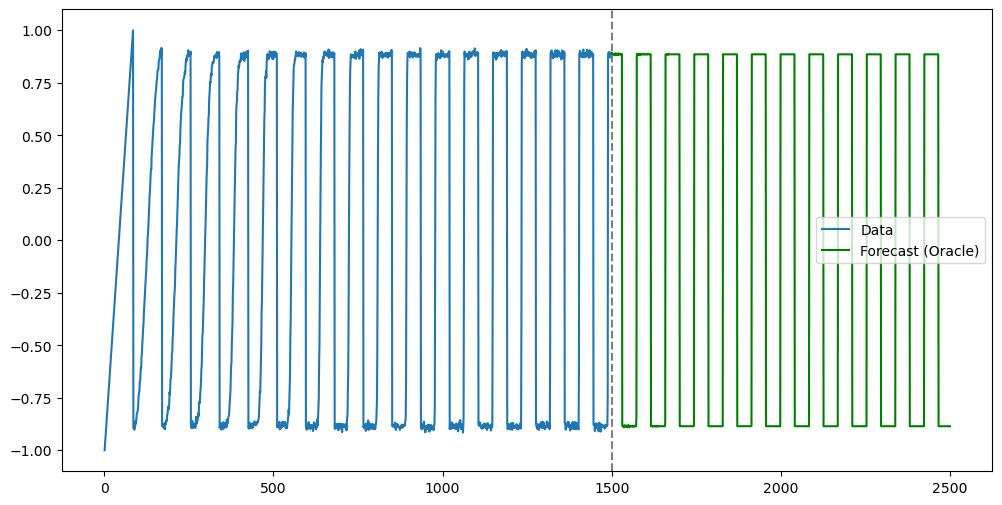

In [3]:
# Oracle Predictions
n_future = 1000
y_extended = np.concatenate([y_sim, np.empty(n_future, dtype=float)])
for t in range(n, n+n_future): 
    y_extended[t] = 0.9 * np.sin(0.5 * np.pi * y_extended[t - truelag])
oracle_preds = y_extended[n:]

n = len(y_sim)
tme = range(1, n+1)
tme_future = range(n+1, n+n_future+1)

plt.figure(figsize = (12, 6))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, oracle_preds, label = 'Forecast (Oracle)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Let us now fit AR(p) to this data. Even if $p$ is taken to be the correct value, this model will not work well (because the actual function which generated the data is nonlinear). 

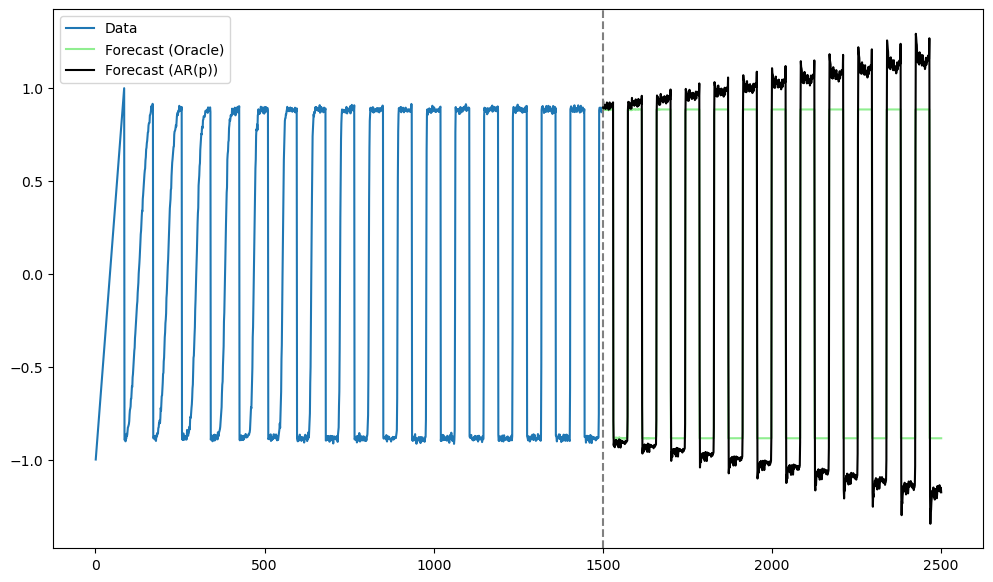

In [4]:
# Let us fit AR(p)
p = truelag
#p = 50
ar = AutoReg(y_sim, lags=p).fit() 

n = len(y_sim)
tme = range(1, n+1)
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start = n, end = n+n_future-1).predicted_mean

plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, oracle_preds, label = 'Forecast (Oracle)', color = 'lightgreen')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The AR predictions seem to be "expanding" compared to the Oracle predictions. 

In [5]:
rmse_ar = np.sqrt(np.mean((fcast - oracle_preds)**2))
print(rmse_ar)

0.18216756914529011


In [6]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


## LSTM

The code below fits the LSTM, and uses it to obtain predictions. 

In [8]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh, batch_first=True)
        # input_size: the number of features in the input x
        # hidden_size: the number of features in the hidden state h(=r in our notation)
        # batch_first: If True, then the input and output tensors are provided 
        #   as (batch, seq_len, feature) instead of (seq_len, batch, feature).
        #   In our case batch = 1, feature = 1
        self.fc  = nn.Linear(nh, 1)          # many-to-many

    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)            
        # out: (batch, seq_len, hidden_size)
        # hc = (h_n, c_n) 
        #   the final hidden state h_n(=r_n) and c_n(=s_n in our notation) 
        #   h_n: (1, hidden_size), c_n: (1, hidden_size)
        out     = self.fc(out)               # (batch, seq_len, 1)
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 40
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    #model.train()  # Set the model to training mode
    opt.zero_grad()

    pred, _ = model(X)  # hidden state auto-reset every epoch
    loss = criterion(pred, Y)
    loss.backward()

    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.134661
epoch  200/1000  |  loss = 0.068940
epoch  300/1000  |  loss = 0.059891
epoch  400/1000  |  loss = 0.042587
epoch  500/1000  |  loss = 0.034438
epoch  600/1000  |  loss = 0.030488
epoch  700/1000  |  loss = 0.027860
epoch  800/1000  |  loss = 0.022685
epoch  900/1000  |  loss = 0.020071
epoch 1000/1000  |  loss = 0.018362


In [10]:
#model.eval()

with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view

    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

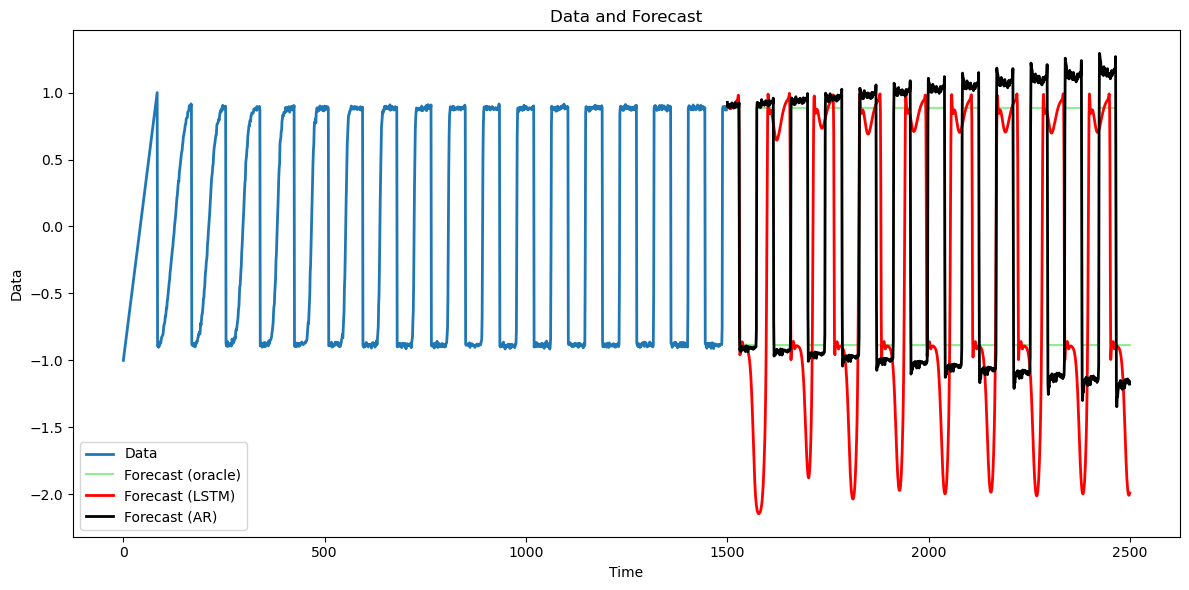

In [11]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n+n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw = 2, label = "Data")
plt.plot(tme_pred_axis, oracle_preds, color = 'lightgreen', label = 'Forecast (oracle)')
plt.plot(tme_pred_axis, lstm_preds_orig, lw = 2, color="r", label = "Forecast (LSTM)")
plt.plot(tme_pred_axis, fcast, lw = 2, color = "black", label = "Forecast (AR)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()


The LSTM predictions (with $nh = 40$) seem more reasonable compared to AR($p$). 

In [12]:
rmse_lstm = np.sqrt(np.mean((lstm_preds_orig - oracle_preds)**2))
print(rmse_ar, rmse_lstm)

0.18216756914529011 1.4123926243769704


LSTM models can be quite unstable. To see this, go back to the simulation data and change sig_noise = 0.01 to sig_noise = 0 or sig_noise = 0.02, and see how the LSTM predictions change. 

## Presence of Trend

LSTM models do not work well where there is trend in the data. In such cases, remove the trend first (say by fitting a line and considering residuals) before fitting models. 

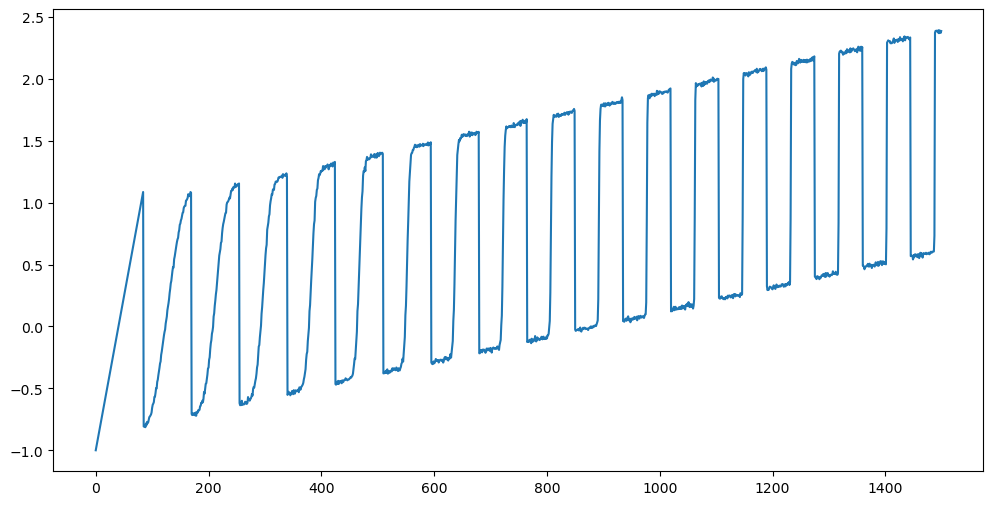

In [13]:
n = 1500
truelag = 85
rng = np.random.default_rng(seed = 0)
#sig_noise = 0.05
sig_noise = 0.01

eps = rng.normal(loc=0, scale=sig_noise, size=n)
y_sim = np.full(shape=n, fill_value=-999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = 0.9 * np.sin(0.5 * np.pi * y_sim[i - truelag]) + eps[i]
#y_sim = y_sim + eps
y_sim = 0.001 * np.arange(1, n + 1) + y_sim

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

This data clearly has a linear trend. AR model will work well (as long as $p$ is correctly chosen). 

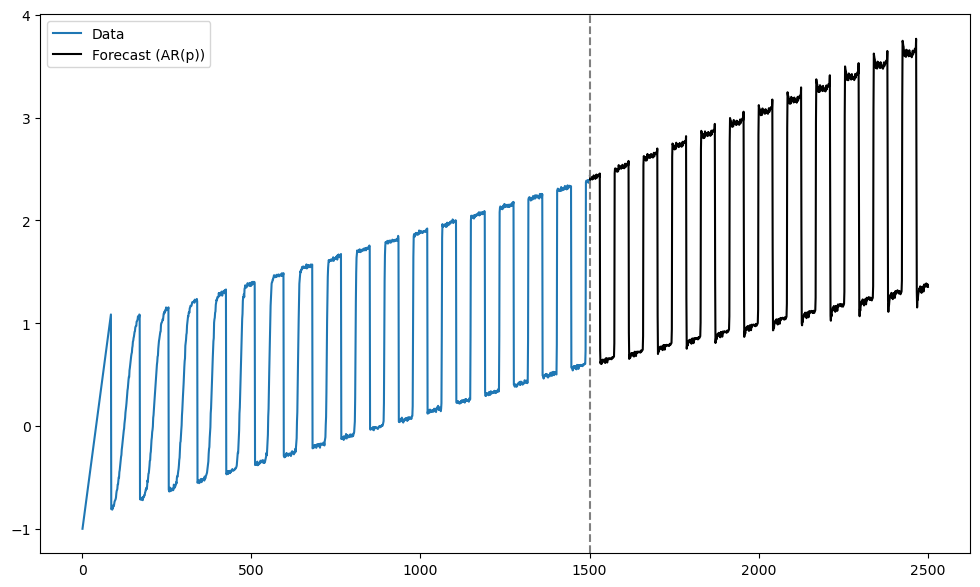

In [14]:
# Let us fit AR(p)
p = truelag
ar = AutoReg(y_sim, lags=p).fit() 

n = len(y_sim)
tme = range(1, n+1)
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start=n, end=n+n_future-1).predicted_mean

plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Now let us use LSTM for prediction. 

In [15]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


epoch  100/1000  |  loss = 0.116244
epoch  200/1000  |  loss = 0.076563
epoch  300/1000  |  loss = 0.059990
epoch  400/1000  |  loss = 0.052457
epoch  500/1000  |  loss = 0.047336
epoch  600/1000  |  loss = 0.042715
epoch  700/1000  |  loss = 0.038708
epoch  800/1000  |  loss = 0.034565
epoch  900/1000  |  loss = 0.029549
epoch 1000/1000  |  loss = 0.025737


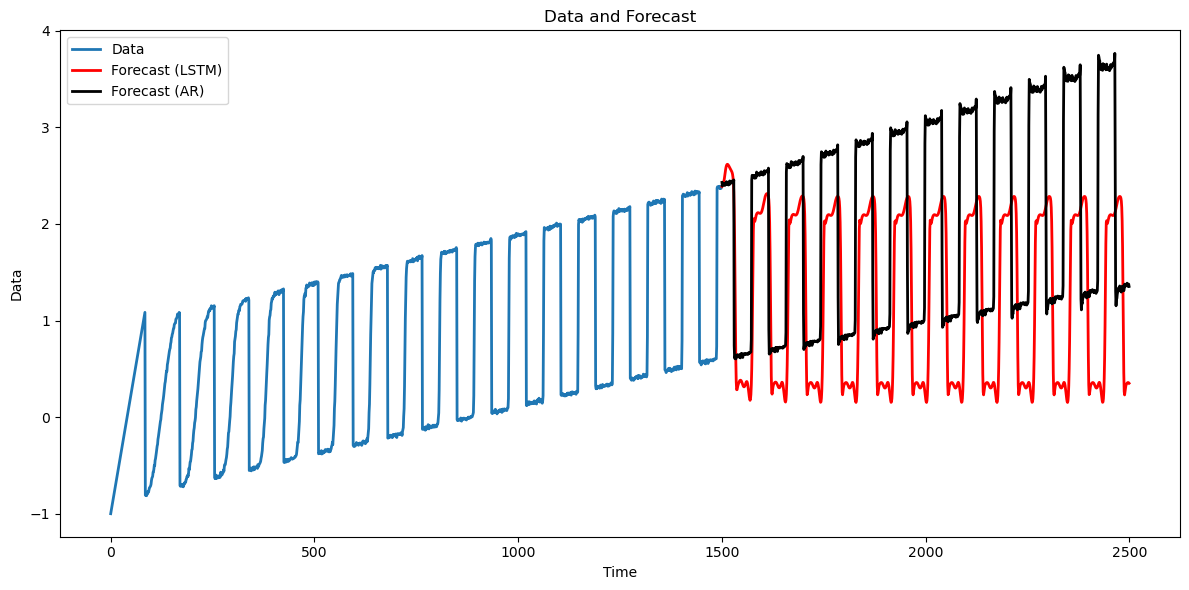

In [16]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh, batch_first=True)
        self.fc  = nn.Linear(nh, 1)      # many-to-many

    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)        # out: (batch, seq_len, hidden_size)
        out     = self.fc(out)           # (batch, seq_len, 1)
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 40
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    #model.train()
    opt.zero_grad()

    pred, _ = model(X)           # hidden state auto-reset every epoch
    loss = criterion(pred, Y)
    loss.backward()

    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

#model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view

    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="Forecast (LSTM)")
plt.plot(tme_pred_axis, fcast, lw=2, color="black", label="Forecast (AR)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

Clearly the predictions flatten out as the prediction horizon increases. This shows that detrending is recommended while working with LSTM models. 

## Airline Passengers Dataset

The airline passengers dataset is a popular dataset for evaluating prediction accuracy of various models. It contains monthly data on the number of international airline passengers (in thousands) from January 1949 to December 1960. 

          time  value
0  1949.000000    112
1  1949.083333    118
2  1949.166667    132
3  1949.250000    129
4  1949.333333    121


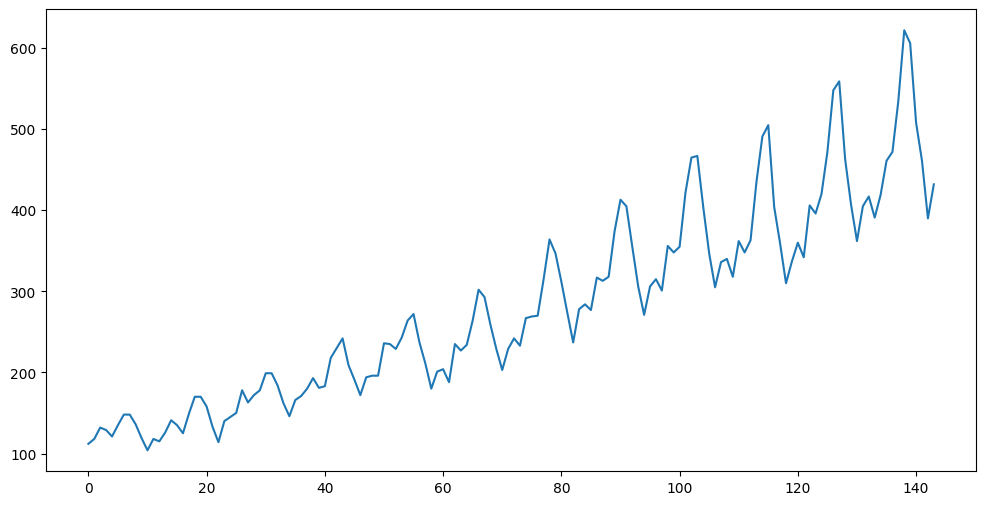

In [16]:
data = sm.datasets.get_rdataset("AirPassengers").data
print(data.head())

y = data['value'].to_numpy()

plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

Let us apply the LSTM model to predict future observations for this dataset. We first remove the increasing trend from the data by fitting a line and taking the residuals. 

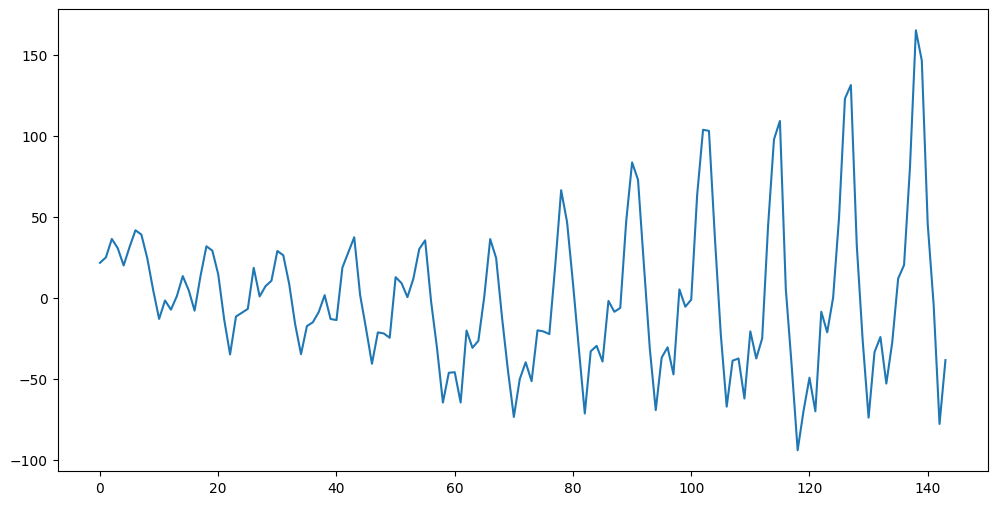

In [17]:
n = len(y)
tme = np.arange(0, n)
X = np.column_stack([np.ones(n), tme])

linmod = sm.OLS(y, X).fit()
y_notrend = linmod.resid

plt.figure(figsize = (12, 6))
plt.plot(y_notrend)
plt.show()

Now let us use LSTM. We will first fit the model to the detrended data, then obtain predictions for the detrended data, and convert these into predictions for the original data.  

In [18]:
mu, sig = y_notrend.mean(), y_notrend.std()
y_std = (y_notrend - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

143


epoch  100/1000  |  loss = 0.133838
epoch  200/1000  |  loss = 0.074407
epoch  300/1000  |  loss = 0.063738
epoch  400/1000  |  loss = 0.053620
epoch  500/1000  |  loss = 0.040483
epoch  600/1000  |  loss = 0.024853
epoch  700/1000  |  loss = 0.014565
epoch  800/1000  |  loss = 0.006797
epoch  900/1000  |  loss = 0.007944
epoch 1000/1000  |  loss = 0.004411


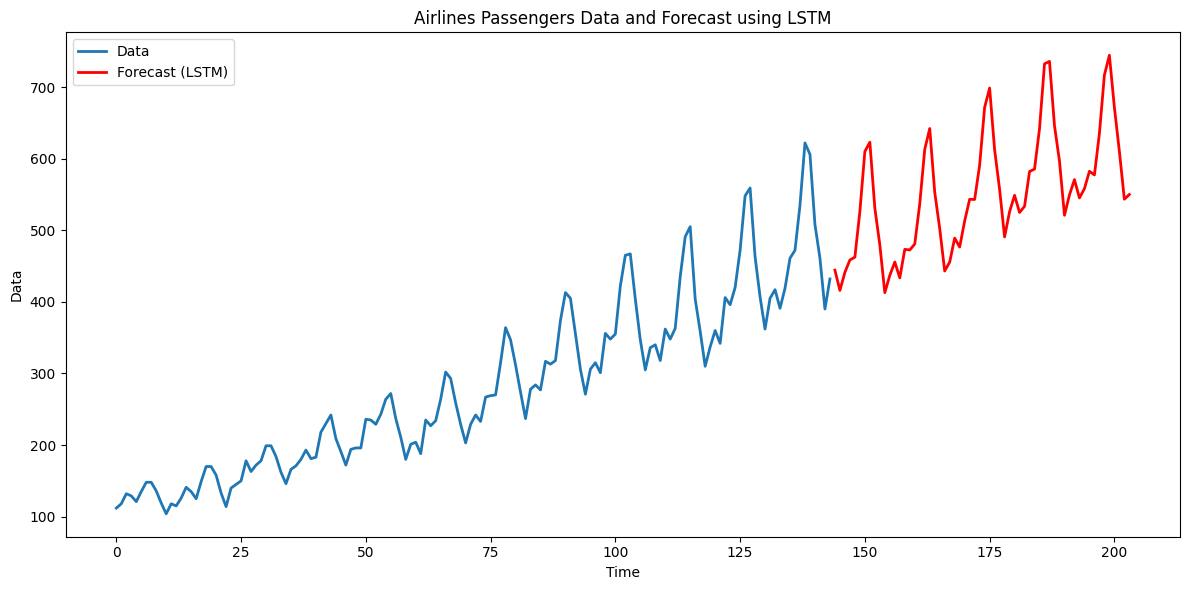

In [ ]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)      # many-to-many

    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)        # out: (batch_size, seq_len, hidden_size)
        out     = self.fc(out)           # (batch_size, seq_len, 1)
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 200
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    #model.train()
    opt.zero_grad()
    pred, _ = model(X)           # hidden state auto-reset every epoch
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

n_future = 60
#model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view

    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

tme_pred_axis = np.arange(n, n+n_future)
lstm_preds_orig = (preds * sig + mu) + linmod.params[0] + linmod.params[1] * tme_pred_axis

plt.figure(figsize = (12,6))
plt.plot(np.arange(n), y, lw = 2, label = "Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw = 2, color = "r", label = "Forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Airlines Passengers Data and Forecast using LSTM")
plt.legend()
plt.tight_layout()
plt.show()